In [1]:
import os
from os.path import join, abspath

import sys
sys.path.append(abspath('..'))
import pandas as pd
import numpy as np

from utils import get_dataset, get_target, Preprocessor

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from warnings import simplefilter
simplefilter("ignore")

RANDOM_STATE = 25
np.random.seed(RANDOM_STATE)

EPS = 10e-3


DATA_PATH = join(os.getcwd(), '..', 'data', 'events')

## 1. Load dataset

In [2]:
event_keys = os.listdir(DATA_PATH)
event_keys = [ek for ek in event_keys if ek.isdigit()]
event_dirs = [join(DATA_PATH, ek) for ek in event_keys]
len(event_dirs)

6

In [3]:
teams, players = get_dataset(event_dirs)
teams = teams.dropna()
players = players.dropna()

Player with id=20170 has no matching team_id.
Player with id=13602 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=18163 has no matching team_id.
Player with id=21217 has no matching team_id.
Player with id=16848 has no matching team_id.
Player with id=21816 has no matching team_id.
Player with id=13618 has no matching team_id.
Player with id=15573 has no matching team_id.
Player with id=19164 has no matching team_id.
Player with id=16080 has no matching team_id.
Player with id=11777 has no matching team_id.


In [4]:
date_cols = ["start_time", "end_time", "start_at", "ends_at"]
team_drop_cols = ["event_fil", "ranking_fil",
                  "is_lan", "is_qual", "prize_pool", "duration", "event_id"]
team_drop_cols += [f"player_id_{i + 1}" for i in range(5)]

In [5]:
df = players.drop(date_cols, axis=1).merge(teams.drop(team_drop_cols + date_cols, axis=1), on="team_id").drop_duplicates()
df["target"] = get_target(df.expected_pts_target, df.wr_target)
df

,rating,dpr,kast,impact,adr,kpr,total_kills,hs,kd,gdr,...,avg_place,winrate,avg_match_intensity,avg_win_intensity,avg_loss_intensity,winstreak,matches_played,wr_target,team_name,target
0,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,5.281250,0.591837,1.453861,1.989617,0.677014,0,49,0.00,betboom,-6.50
1,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,4.875000,0.500000,1.062761,1.409098,0.716424,2,16,0.00,betboom,-6.50
2,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,4.800000,0.512821,1.373098,2.027451,0.684306,0,39,0.00,betboom,-6.50
3,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,4.875000,0.619048,1.160991,1.434571,0.716424,4,21,0.00,betboom,-6.50
4,1.18,0.68,73.2,1.31,82.9,0.74,1591,56.2,1.09,6.6,...,14.500000,0.600000,0.977839,1.183785,0.668919,1,5,0.00,betboom,-6.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631687,1.03,0.70,70.8,1.09,70.8,0.66,150,61.3,0.95,4.3,...,8.333333,0.473684,1.150189,1.670708,0.681721,0,19,0.25,fnatic,-7.75
631688,1.03,0.70,70.8,1.09,70.8,0.66,150,61.3,0.95,4.3,...,14.500000,0.600000,1.564998,2.133971,0.711538,2,5,0.25,fnatic,-7.75
631754,1.03,0.70,70.8,1.09,70.8,0.66,150,61.3,0.95,4.3,...,8.150000,0.538462,1.421059,2.080737,0.651434,1,26,0.25,fnatic,-7.75
631755,1.03,0.70,70.8,1.09,70.8,0.66,150,61.3,0.95,4.3,...,8.333333,0.473684,1.150189,1.670708,0.681721,0,19,0.25,fnatic,-7.75


## 2. Modelling

In [6]:
event_keys

['7755', '7553', '7437', '7148', '7440', '6976']

In [7]:
train_events = [7755, 7440, 7437, 6976, 7553]
test_events = [int(ek) for ek in event_keys if int(ek) not in train_events]

In [8]:
target_col = ["target"]

drop_cols = ["event_id", "player_id", "team_id", "team_name", "player_name", # meta
             "duration", "maps_played", "kpr",                               # correlated
             "wr_target", "expected_pts_target",                             # unknown values
             "event_fil"] + target_col

cat_cols = ["ranking_fil"]
bin_cols = ["has_roster_change", "is_lan", "is_qual", "is_awp"]

df[bin_cols] = df[bin_cols].astype(np.float64)
df[target_col] = df[target_col].astype(np.float64)

In [9]:
train = df[df.event_id.isin(train_events)].sample(frac=1).reset_index(drop=True)
test = df[df.event_id.isin(test_events)].sample(frac=1).reset_index(drop=True)

X_train, y_train = train.drop(drop_cols, axis=1), train[target_col].astype(np.float64)
X_test, y_test = test.drop(drop_cols, axis=1), test[target_col].astype(np.float64)

In [10]:
X_test.columns

Index(['rating', 'dpr', 'kast', 'impact', 'adr', 'total_kills', 'hs', 'kd',
       'gdr', 'avg_rounds_played', 'apr', '1v1_wr', 'opening_ratio',
       'opening_rating', 'is_awp', 'ranking_fil', 'is_lan', 'is_qual',
       'prize_pool', 'has_roster_change', 'world_ranking', 'points',
       'avg_place', 'winrate', 'avg_match_intensity', 'avg_win_intensity',
       'avg_loss_intensity', 'winstreak', 'matches_played'],
      dtype='object')

In [11]:
X_train.columns

Index(['rating', 'dpr', 'kast', 'impact', 'adr', 'total_kills', 'hs', 'kd',
       'gdr', 'avg_rounds_played', 'apr', '1v1_wr', 'opening_ratio',
       'opening_rating', 'is_awp', 'ranking_fil', 'is_lan', 'is_qual',
       'prize_pool', 'has_roster_change', 'world_ranking', 'points',
       'avg_place', 'winrate', 'avg_match_intensity', 'avg_win_intensity',
       'avg_loss_intensity', 'winstreak', 'matches_played'],
      dtype='object')

In [12]:
pipe = Pipeline([
    ("preprocessor", Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)),
    ("estimator", Ridge(alpha=1))
])

In [13]:
pipe.fit(X_train, y_train)
y_preds = pipe.predict(X_test)

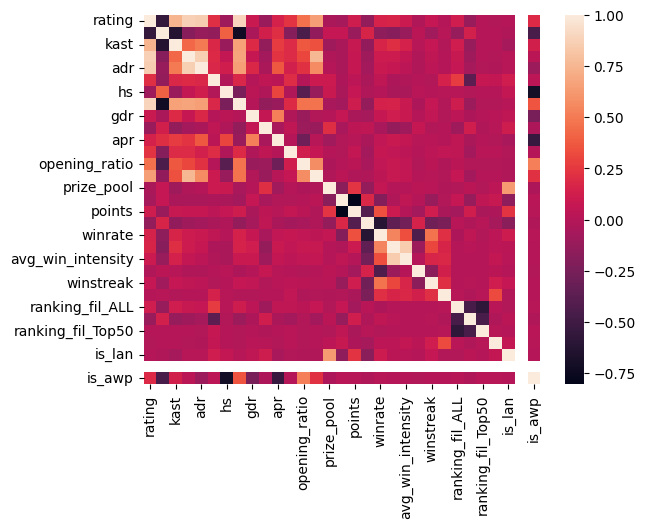

In [14]:
p = Preprocessor(cat_cols=cat_cols, bin_cols=bin_cols)
p.fit(X_train, y_train)
X_train_prep = p.transform(X_train)

sns.heatmap(X_train_prep.corr());

In [15]:
n = 15

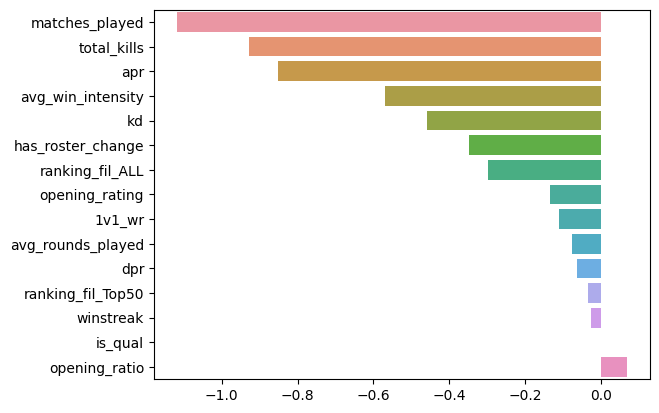

In [16]:
idx = np.argsort(pipe["estimator"].coef_.ravel())[:n]
sns.barplot(x=pipe["estimator"].coef_.ravel()[idx],
            y=pipe["preprocessor"].features.ravel()[idx]);

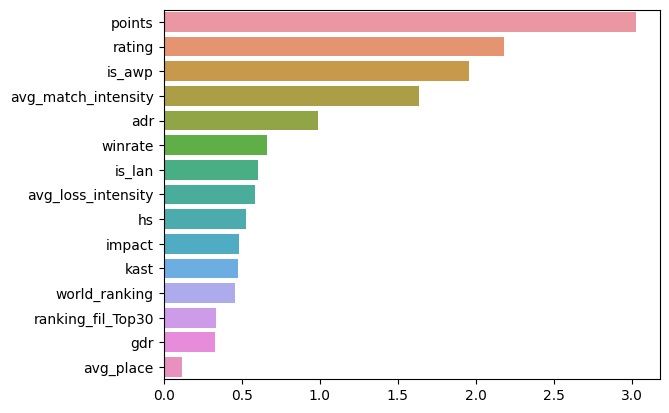

In [17]:
idx = np.argsort(pipe["estimator"].coef_.ravel())[::-1][:n]
sns.barplot(x=pipe["estimator"].coef_.ravel()[idx],
            y=pipe["preprocessor"].features.ravel()[idx]);

In [18]:
final = test[target_col + ["team_name", "player_name"]]
final["pred_target"] = y_preds
final = final.groupby(["player_name"]).max()
final.sort_values(["target"], ascending=False).head(10)

,target,team_name,pred_target
player_name,,,
donk,22.750000,spirit,34.587601
torzsi,19.000000,mouz,16.103122
m0nesy,18.000000,g2,21.248849
brollan,17.750000,mouz,21.105244
sh1ro,17.000000,spirit,31.396750
jimpphat,17.000000,mouz,18.571715
flamez,13.666667,vitality,14.996355
jl,13.250000,natus-vincere,18.267347
spinx,12.833333,vitality,16.824644


In [19]:
final.sort_values(["pred_target"], ascending=False).head(10)

,target,team_name,pred_target
player_name,,,
donk,22.750000,spirit,34.587601
sh1ro,17.000000,spirit,31.396750
zont1x,10.500000,spirit,25.464613
magixx,10.250000,spirit,23.572400
chopper,7.500000,spirit,21.457711
m0nesy,18.000000,g2,21.248849
brollan,17.750000,mouz,21.105244
zywoo,12.166667,vitality,21.061585
ax1le,12.600000,cloud9,20.813379


In [20]:
final['pred_target'] *= y_test.max()[0] / final['pred_target'].max()

In [21]:
final.sort_values(["pred_target"], ascending=False).head(12)

,target,team_name,pred_target
player_name,,,
donk,22.750000,spirit,22.750000
sh1ro,17.000000,spirit,20.651217
zont1x,10.500000,spirit,16.749353
magixx,10.250000,spirit,15.504749
chopper,7.500000,spirit,14.113813
m0nesy,18.000000,g2,13.976434
brollan,17.750000,mouz,13.881978
zywoo,12.166667,vitality,13.853261
ax1le,12.600000,cloud9,13.690003


In [22]:
from utils import validate

validate(y_test.values, y_preds)

,mse,mae,ndcg
0,24.250655,3.965197,0.941487
